In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [87]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Texas - total electricity consumption - quarterly (short tons).csv')
df.head()

,Texas - electric power (total coal consumption) - quarterly,short tons
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


In [88]:
df.tail()

,Texas - electric power (total coal consumption) - quarterly,short tons
75,2019 Q4,13866538
76,2020 Q1,11029285
77,2020 Q2,12950538
78,2020 Q3,17219614
79,2020 Q4,14869537


In [89]:
df.shape

(80, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Texas - electric power (total coal consumption) - quarterly   80 non-null     object
 1    short tons                                                   80 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [7]:
df.isnull().sum()

Texas - electric power (total coal consumption) - quarterly     0
 short tons                                                     0
dtype: int64

In [90]:
time = pd.date_range(start='1/1/2001',periods=80,freq='Q')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Texas - electric power (total coal consumption) - quarterly '],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [91]:
len(time)

80

In [92]:
df.columns = ['short_tons']

In [93]:
df.head()

,short_tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084


In [94]:
df.tail()

,short_tons
time_stamp,
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538
2020-09-30,17219614
2020-12-31,14869537


In [95]:
df

,short_tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084
...,...
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538


In [22]:
plt.rcParams['figure.figsize'] = [15,8]

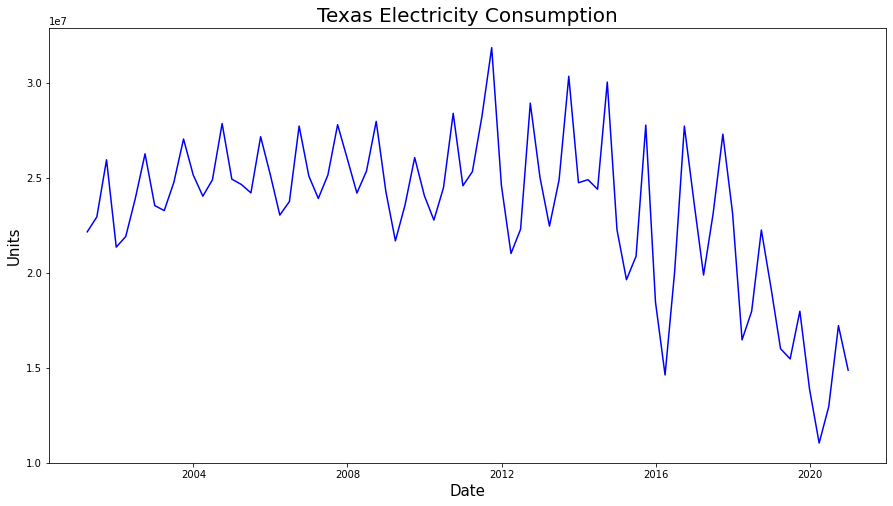

In [23]:
plt.plot(df,color='blue')
plt.title('Texas Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [96]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [97]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['short_tons'] = df['short_tons'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0.1, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [98]:
train_size = 68
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 4
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [99]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(64, 1, 4)
(64, 1)
(8, 1, 4)
(8, 1)


In [30]:
!pip install -q -U keras-tuner

In [32]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [33]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('first_lstm_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(LSTM(hp.Int('final_lstm_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [34]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='texas_consum_2')

In [35]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
first_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [36]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=8,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 47s]
val_mape: 160.58621215820312

Best val_mape So Far: 35.21929740905762
Total elapsed time: 00h 13m 17s
INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.results_summary()

Results summary
Results in project/texas_consum_2
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_lstm_layer: 64
first_recurrent_dropout: 0.2
final_lstm_layer: 48
last_recurrent_dropout: 0.2
dense_layer_1: 8
Dropout_rate: 0.1
learning_rate: 0.00047899997254004164
Score: 35.21929740905762
Trial summary
Hyperparameters:
first_lstm_layer: 64
first_recurrent_dropout: 0.2
final_lstm_layer: 56
last_recurrent_dropout: 0.2
dense_layer_1: 32
Dropout_rate: 0.4
learning_rate: 0.00018858096258871453
Score: 35.86772155761719
Trial summary
Hyperparameters:
first_lstm_layer: 24
first_recurrent_dropout: 0.4
final_lstm_layer: 104
last_recurrent_dropout: 0.6
dense_layer_1: 16
Dropout_rate: 0.2
learning_rate: 0.00024346586824137506
Score: 36.214134216308594
Trial summary
Hyperparameters:
first_lstm_layer: 80
first_recurrent_dropout: 0.2
final_lstm_layer: 48
last_recurrent_dropout: 0.4
dense_layer_1: 80
Dropout_rate: 0.30000000000000004
learning_rate

In [38]:
from warnings import filterwarnings
filterwarnings('ignore')

In [39]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17664     
                                                                 
 lstm_1 (LSTM)               (None, 48)                21696     
                                                                 
 dense (Dense)               (None, 8)                 392       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 39,761
Trainable params: 39,761
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras import optimizers

In [103]:
model = Sequential()
model.add(LSTM(32,activation='relu',input_shape=(1,look_back), return_sequences=True, recurrent_dropout = 0.1))
model.add(LSTM(32,activation='relu',recurrent_dropout = 0.1))
model.add(Dense(80,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0008762967221693925)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 8, epochs = 1000)

Epoch 1/1000
8/8 [==============================] - 6s 99ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 5/1000
8/8 [==============================] - 0s 7ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 100.0000 - mape: 100.0000 - val_loss: 100.0000 - val_mape: 100.0000
Epoch 8/1000
8/8 [=

In [104]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : 8.55 
Test MAPE : 15.01 


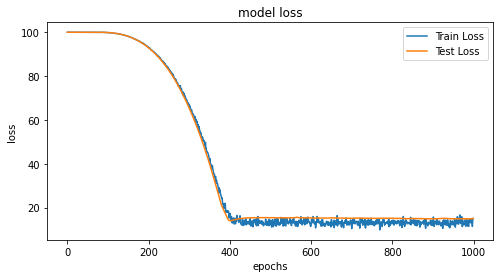

In [105]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [47]:
import seaborn as sns

In [106]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(64,72)]
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Consumption', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

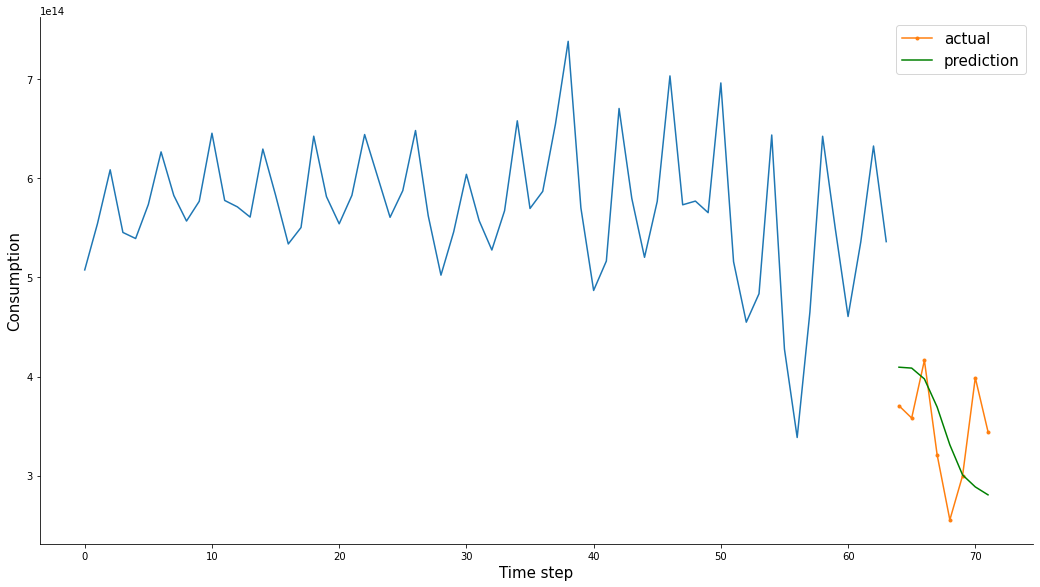

In [107]:
test_predict_scaled = model.predict(testX)
test_predict_inv = scaler.inverse_transform(test_predict_scaled)
prediction_plot(testY, test_predict_inv,look_back)